## Create Dependencies

In [71]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests as rq
import random as rnd
import gmaps
import os
#import io
import json
#import time

# Import API key
import config

# Configure gmaps
gkey = config.gkey
gmaps.configure(api_key=gkey)

## Create and set the path

In [72]:
notebook_path = os.getcwd()
parent_dir = notebook_path[0:-4]

## Store csv filenames. Iterate through the filename list and get csv from path and store in variables

In [73]:
dataset_filelist = ["1_county_level_confirmed_cases.csv","2_cases_and_deaths_by_county_timeseries.csv","weekly-claims-by-county-twc.csv","texas_county_med_income.csv"]
for csv in dataset_filelist:   
    for root, dirs, files in os.walk(parent_dir):
        if csv in files:
            if csv == dataset_filelist[0]:
                covid_dataset1 = (os.path.join(root, csv))
            elif csv == dataset_filelist[1]:
               covid_dataset2 =  (os.path.join(root, csv))
            elif csv == dataset_filelist[2]:
               unemployment_dataset =  (os.path.join(root, csv))
            else:
                texas_median_income = (os.path.join(root, csv))
print(texas_median_income)

c:\Users\Inkosi\Desktop\School(BootCamp)\Covid-19-and-Low-Income-Communities\docs\data_resources\texas_county_med_income.csv


## Use pandas and read contents of csv into a DataFrame

In [74]:
ConfirmedByCounty_Covid = pd.read_csv('https://query.data.world/s/tmtcsyi5cadisfgsziloo4c7sesaon')
CaseDeathsBy_County_timeseries = pd.read_csv('https://query.data.world/s/ipaqguramdyfp27ppx72n3sgtkj6xu', parse_dates=['date'])
unemployment_dataset = pd.read_csv(unemployment_dataset)
texas_median_income = pd.read_csv(texas_median_income)

## Remove ("$",",") characters from the Texas Median Income dataset and convert to float

In [75]:
texas_median_income['Median Household Income'] = texas_median_income['Median Household Income'].str.replace('$','').str.replace(',','').astype(float)

In [76]:
texas_median_income.head()

,County,Median Household Income
0,Anderson,45969.0
1,Andrews,84946.0
2,Angelina,46653.0
3,Aransas,46912.0
4,Archer,61190.0


In [77]:
texas_low_income = texas_median_income.loc[(texas_median_income['Median Household Income'] > 57000)]
texas_low_income.describe()

,Median Household Income
count,56.000000
mean,69560.303571
std,11444.745846
min,57052.000000
25%,60789.500000
50%,66080.000000
75%,76322.000000
max,102858.000000


## Incomes that qualify as low imcome per HUD data. Less than or equal to 57K but greater than 36K

In [78]:
texas_low_income = texas_median_income.loc[(texas_median_income['Median Household Income'] <= 57000) & (texas_median_income['Median Household Income'] > 36000)]
texas_low_income.head()

,County,Median Household Income
0,Anderson,45969.0
2,Angelina,46653.0
3,Aransas,46912.0
6,Atascosa,50594.0
8,Bailey,45051.0


## Incomes that qualify as very low imcome per HUD data. Less than or equal to 36K but greater than 26K

In [79]:
texas_verylow_income = texas_median_income.loc[(texas_median_income['Median Household Income'] <= 36000) & (texas_median_income['Median Household Income'] > 26000)]
texas_verylow_income.head()

,County,Median Household Income
23,Brooks,30116.0
65,Duval,35156.0
95,Hall,32597.0
161,Maverick,35594.0
163,Menard,35881.0


## Covid-19 Dataset that gives most recent case and death numbers as of 2020-11-13
* Cleansed Data to get rid of one row in Latitude and Longitude that had NaN

In [80]:
Texas_ConfirmedByCounty_Covid = ConfirmedByCounty_Covid.loc[ConfirmedByCounty_Covid['state'] == 'Texas'].dropna(subset=['lat','lon'])
Texas_ConfirmedByCounty_Covid.head()

,last_update,location_type,state,county_name,county_name_long,fips_code,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
2599,2020-11-18 01:27:26 UTC,county,Texas,Anderson,"Anderson, Texas, US",48001.0,31.815347,-95.653548,Micropolitan,57863.0,3065,5296.99,45,77.77
2600,2020-11-18 01:27:26 UTC,county,Texas,Andrews,"Andrews, Texas, US",48003.0,32.304686,-102.637655,Micropolitan,17818.0,896,5028.62,12,67.35
2601,2020-11-18 01:27:26 UTC,county,Texas,Angelina,"Angelina, Texas, US",48005.0,31.254573,-94.609015,Micropolitan,87607.0,2446,2792.01,95,108.44
2602,2020-11-18 01:27:26 UTC,county,Texas,Aransas,"Aransas, Texas, US",48007.0,28.105562,-96.999505,Medium metro,24763.0,375,1514.36,18,72.69
2603,2020-11-18 01:27:26 UTC,county,Texas,Archer,"Archer, Texas, US",48009.0,33.615700,-98.687546,Small metro,8789.0,207,2355.22,2,22.76


In [81]:
Texas_ConfirmedByCounty_Covid = Texas_ConfirmedByCounty_Covid.drop(columns=["location_type","state","county_name_long","fips_code"])

In [82]:
covid_cumlative_groupby = Texas_ConfirmedByCounty_Covid.groupby('NCHS_urbanization')
covid_cumlative_groupby['county_name'].count()

NCHS_urbanization
Large central metro      6
Large fringe metro      29
Medium metro            25
Micropolitan            46
Non-core               126
Small metro             22
Name: county_name, dtype: int64

In [83]:
Texas_ConfirmedByCounty_Covid.loc[Texas_ConfirmedByCounty_Covid['NCHS_urbanization'] == 'Large central metro'].sort_values('total_population',ascending=False)

,last_update,county_name,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
2699,2020-11-18 01:27:26 UTC,Harris,29.858649,-95.393395,Large central metro,4602523.0,175959,3823.10,2919,63.42
2655,2020-11-18 01:27:26 UTC,Dallas,32.766706,-96.777960,Large central metro,2586552.0,111174,4298.15,1391,53.78
2818,2020-11-18 01:27:26 UTC,Tarrant,32.771438,-97.291016,Large central metro,2019977.0,83647,4140.99,943,46.68
2613,2020-11-18 01:27:26 UTC,Bexar,29.449287,-98.520197,Large central metro,1925865.0,70236,3646.98,1453,75.45
2825,2020-11-18 01:27:26 UTC,Travis,30.334320,-97.785356,Large central metro,1203166.0,35020,2910.65,469,38.98
2641,2020-11-18 01:27:26 UTC,Collin,33.188201,-96.572644,Large central metro,944350.0,21689,2296.71,222,23.51


<ipython-input-84-ac8f23676f6b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  combined = covid_cumlative_groupby['confirmed','deaths'].sum()


<AxesSubplot:xlabel='NCHS_urbanization'>

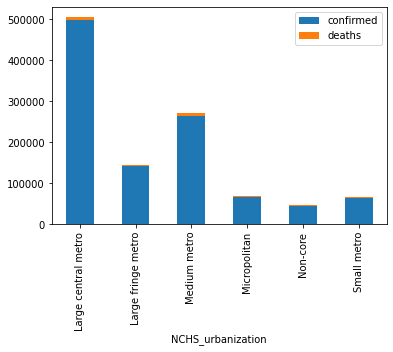

In [84]:
combined = covid_cumlative_groupby['confirmed','deaths'].sum()
combined.plot(kind='bar', stacked=True)

In [85]:
urban_death = covid_cumlative_groupby['deaths'].mean()

<AxesSubplot:xlabel='NCHS_urbanization'>

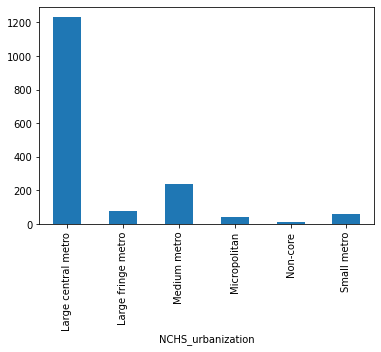

In [86]:
urban_death.plot.bar()

<AxesSubplot:xlabel='NCHS_urbanization'>

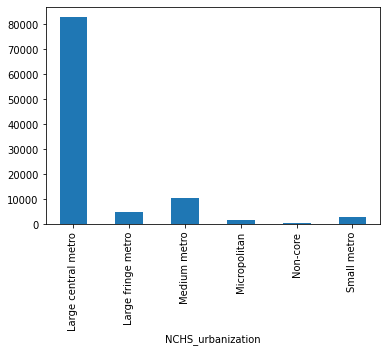

In [88]:
urban_cases = covid_cumlative_groupby['confirmed'].mean()
urban_cases.plot.bar()

In [112]:
covid_cumlative_groupby['confirmed'].mean()

NCHS_urbanization
Large central metro    82124.833333
Large fringe metro      4850.965517
Medium metro           10302.760000
Micropolitan            1415.478261
Non-core                 339.880952
Small metro             2827.636364
Name: confirmed, dtype: float64

## Select only data related to the state of Texas and drop all column with headers starting with "new"

In [63]:
columns_todrop = []
Texas_CaseDeathsBy_County_timeseries = CaseDeathsBy_County_timeseries.loc[(CaseDeathsBy_County_timeseries['state'] == 'Texas') & (CaseDeathsBy_County_timeseries['location_name'] != 'Unassigned') & (CaseDeathsBy_County_timeseries['location_name'] != 'Out of TX')]
Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.loc[Texas_CaseDeathsBy_County_timeseries['date'] >= '2020-03-01']
for column in Texas_CaseDeathsBy_County_timeseries.columns:
    if column.startswith('new'):
        columns_todrop.append(column)
for drop in columns_todrop:
    Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.drop(columns=drop)
Texas_CaseDeathsBy_County_timeseries.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
780939,84048001,county,48001.0,Anderson,Texas,2020-03-01,57863.0,0,0.0,0,0.0
780940,84048001,county,48001.0,Anderson,Texas,2020-03-02,57863.0,0,0.0,0,0.0
780941,84048001,county,48001.0,Anderson,Texas,2020-03-03,57863.0,0,0.0,0,0.0
780942,84048001,county,48001.0,Anderson,Texas,2020-03-04,57863.0,0,0.0,0,0.0
780943,84048001,county,48001.0,Anderson,Texas,2020-03-05,57863.0,0,0.0,0,0.0


## Drop all other unused columns

In [64]:
Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.drop(columns=["uid","location_type","state"]).set_index('date')

In [65]:
Texas_CaseDeathsBy_County_timeseries

,fips_code,location_name,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
date,,,,,,,
2020-03-01,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-02,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-03,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-04,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-05,48001.0,Anderson,57863.0,0,0.00,0,0.00
...,...,...,...,...,...,...,...
2020-11-12,48507.0,Zavala,12131.0,498,4105.19,21,173.11
2020-11-13,48507.0,Zavala,12131.0,501,4129.92,21,173.11
2020-11-14,48507.0,Zavala,12131.0,527,4344.24,21,173.11


In [145]:
# Gets all rows last day of month
test = Texas_CaseDeathsBy_County_timeseries[(Texas_CaseDeathsBy_County_timeseries.index + pd.Timedelta(days=1)).day == 1]
test2 = Texas_CaseDeathsBy_County_timeseries.loc['2020-11-11']
test = test.append(test2)

In [146]:
test.loc['2020-11-11']

,fips_code,location_name,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
date,,,,,,,
2020-11-11,48001.0,Anderson,57863.0,3035,5245.15,42,72.59
2020-11-11,48003.0,Andrews,17818.0,781,4383.21,11,61.74
2020-11-11,48005.0,Angelina,87607.0,2380,2716.68,93,106.16
2020-11-11,48007.0,Aransas,24763.0,369,1490.13,18,72.69
2020-11-11,48009.0,Archer,8789.0,187,2127.66,1,11.38
...,...,...,...,...,...,...,...
2020-11-11,48499.0,Wood,43815.0,722,1647.84,44,100.42
2020-11-11,48501.0,Yoakum,8571.0,464,5413.60,10,116.67
2020-11-11,48503.0,Young,18114.0,704,3886.50,13,71.77


In [97]:
unemployment_claims = unemployment_dataset.copy()
unemployment_claims = unemployment_claims.transpose()
unemployment_claims = unemployment_claims.fillna(0)

In [98]:
unemployment_claims.columns = [''] * len(unemployment_claims.columns)
unemployment_header = unemployment_claims.iloc[0]
unemployment_claims = unemployment_claims[1:]
unemployment_claims.columns = unemployment_header
unemployment_claims.index.names = ['Date']
unemployment_claims.columns.names = ['']

In [99]:
unemployment_claims.index = pd.to_datetime(unemployment_claims.index)

In [102]:
unemployment_claims.loc['2020-10-31']


,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-31,42,17,77,32,3,1,46,28,3,23,...,24,422,28,7,74,31,14,16,20,11


In [101]:
unemployment_claims

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-31,42,17,77,32,3,1,46,28,3,23,...,24,422,28,7,74,31,14,16,20,11
2020-10-24,79,17,89,22,6,0,36,23,1,13,...,51,409,34,8,65,33,8,17,27,18
2020-10-17,54,17,80,40,5,1,35,26,4,24,...,43,434,30,15,45,26,6,17,27,12
2020-10-10,63,30,98,18,10,2,40,32,3,11,...,24,484,41,11,57,38,6,19,22,16
2020-10-03,64,25,103,26,6,1,55,37,5,18,...,15,574,41,12,79,45,9,11,19,16
2020-09-26,64,21,100,35,5,1,56,30,4,22,...,26,564,39,18,59,46,7,18,29,11
2020-09-19,61,18,119,25,4,0,70,29,3,25,...,23,526,42,13,59,29,5,7,23,21
2020-09-12,66,32,107,31,5,0,67,42,8,4,...,19,524,41,8,51,56,12,13,23,20
2020-09-05,85,22,171,50,6,3,96,45,9,41,...,29,800,54,19,86,83,10,22,34,18


In [52]:
locations = Texas_ConfirmedByCounty_Covid[['lat','lon']]
confirmed = Texas_ConfirmedByCounty_Covid['confirmed']

In [53]:
zero_coor = (31.81,-95.65)
figure_layout = {'width': '1050px', 'margin': '0 auto 0 auto'}
# Plot Heatmap
fig = gmaps.figure(center=zero_coor,zoom_level=5.5,layout=figure_layout,map_type="TERRAIN")

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=confirmed,
                                 dissipating=False, max_intensity=.5,
                                 point_radius=.5)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='1050px'))

In [58]:
%reset